# Lithology Classification
1. [Introduction](#introduction)<br>
2. [Exploratory Data Analysis](#eda)<br>
    2.1 [Data Description](#datadescription)<br>
    2.2 [Data visualization](#datavisualization)<br>
    2.3 [Feature correlation check](#featurecorrelationcheck)
3. [Feature selection and feature engineer](#featureselectionandfeatureengineer)
4. [Build Machine Learning Models](#buildMachineLearningmodels)<br>
    4.1 [SVM](#SVM)<br>
    4.2 [Gradient Boosting Tree](#gradientboostingtree)<br>
6. [Model Validation with Blind Data](#modelvalidationwithblinddata)
7. [Summary](#Summary)

In [75]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn import impute

import xgboost as xgb
from xgboost.sklearn import  XGBClassifier

## 1. Introduction <a name="introduction"></a>
In this project, I am going to demonstrate using the machine learning algorithms to identify lithofacies based on well-log measurements. A supervised-learning algorithm Gradient Boosting Tree is trained by 9 well-log data. These wells have already had lithofacies classes assigned. Once the classifier is trained, I'll use it to assign facies to wells that have not been described.

## 2. Exploratory Data Analysis<a name="eda"></a>

### 2.1 Data Description<a name="datadescription"></a>
The demo data set was from Univeristy of Kansas and they were collected on the Hugoton and Panoma gas fields. For more on the origin of the data, see Dubois et al. (2007) and the Jupyter notebook that accompanies this tutorial at [http://github.com/seg](http://github.com/seg).

The data set included 9 wells data, and there were 3232 observations. There are 9 columns in the data table, including 5 wireline log measurements, 2 indicator variables derived from geologic knowledge, a facies lable at half foot intervals, and a relative position. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


In [2]:
#load the training data
filename = 'training_data.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
3227,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [4]:
training_data.describe()


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


The quick view of the statistics of the numerical features of the training data. There are 3232 observations. The statistics indicate that these dataset had been preprocessed since not many stranged values observed as in the regular well logs.

### 2.1 Data Visualization<a name="datavisualization"></a>

In [5]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [6]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
#     cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
#                                 'SiSh', ' MS ', ' WS ', ' D  ', 
#                                 ' PS ', ' BS ']))
#     cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

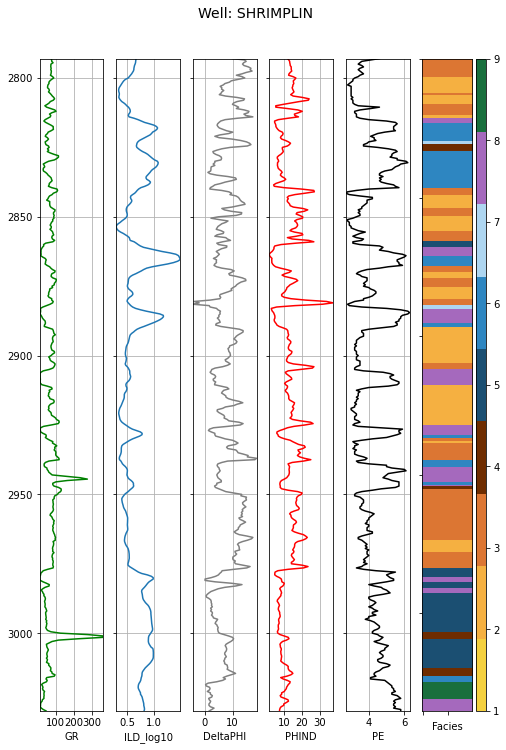

In [7]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

The Y axis is the depth and the x axis is the feature value. This is a typical visualizaiton of the well log data. The Stratigraphic formation of rocks was also presented in this figure.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

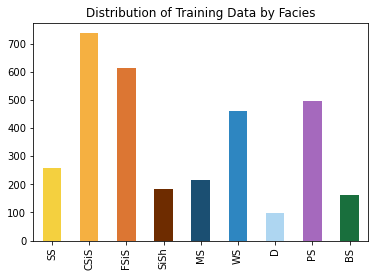

In [8]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

We can observed some degree of data imbalance in the training dataset. 

### 2.3 Feature correlation check<a name="featurecorrelationcheck"></a>

C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key

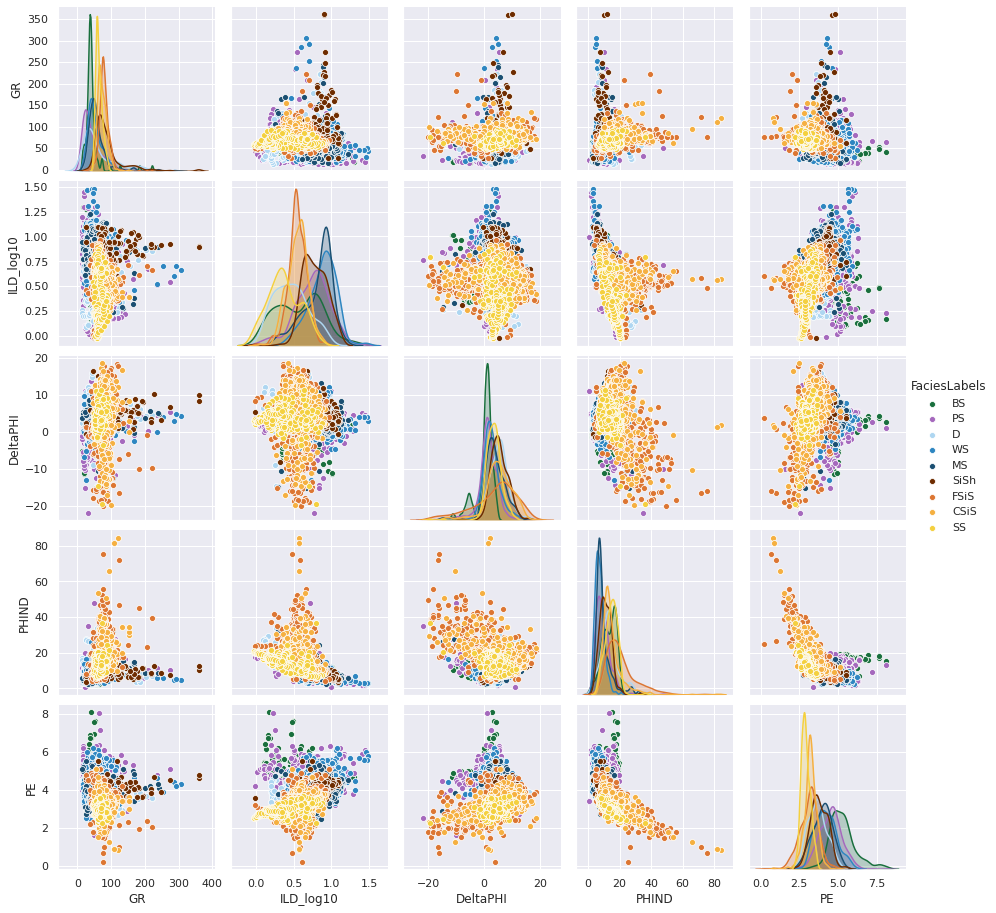

In [9]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

The crossplots are used to visualize how tow features vary with rock type. We created a matrix of crossplots to visualize the variation between log measurements in the data set.

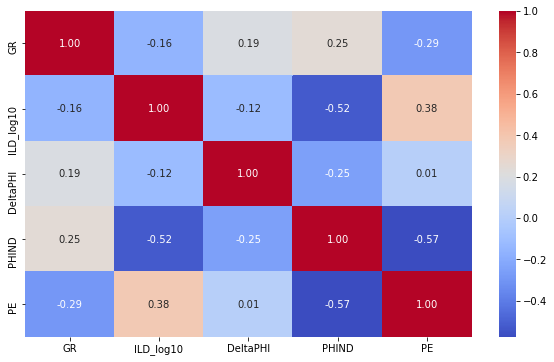

In [10]:
fig, ax = plt.subplots(figsize = (10,6))
cm_df = sns.heatmap(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1).corr(), annot = True, fmt = ".2f", cmap = 'coolwarm', ax = ax)

Combining the pairplot and the correlation heat map, we can exam the highly correlated features. In these data set, we did not observe highly correlated feature pairs.

## 3. Feature selection and feature engineer<a name=" Featureselectionandfeatureengineer"></a>

The relationship between the well-log features and the lithofacies is complicated. In the training dataset, we only have 5 well-log features and 2 derived features. To reveal the underline relationship, we proposed the following feature augmentation.
1. neighboring value
2. gradient
3. quadratic expansion

In [11]:
# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

In [12]:
# Store features and labels
X = training_data[feature_names].values 
y = training_data['Facies'].values 

In [13]:
# Store well labels and depths
well = training_data['Well Name'].values
depth = training_data['Depth'].values

# Fill 'PE' missing values with mean
imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)

In [14]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [15]:
X_aug, padded_rows = augment_features(X, well, depth)

In [16]:
deg = 2
poly = preprocessing.PolynomialFeatures(deg, interaction_only=False)
X_aug2 = poly.fit_transform(X_aug)

In [76]:
X_aug.shape

(3232, 28)

In [77]:
X_aug2.shape

(3232, 435)

## 4.Build Machine Learning Models <a name=" buildmachinelearningmodels"></a>

To evaluate the accuracy of the classifier, we will remove one well from the training set. We will compare the predicted facies with the pre-labeled value.

In [17]:
#leave a well for blind test later 
blind = X_aug2[training_data['Well Name'] == 'CHURCHMAN BIBLE']

In [18]:
blind_y = y[training_data['Well Name'] == 'CHURCHMAN BIBLE']

In [19]:
blind.shape

(404, 435)

In [20]:
X_aug_tr = X_aug2[training_data['Well Name'] != 'CHURCHMAN BIBLE']

In [21]:
y_tr = y[training_data['Well Name'] != 'CHURCHMAN BIBLE']

In [22]:
X_aug_tr.shape

(2828, 435)

Many machine-learning algorithms assume the feature data are normally distributed (i.e., Gaussian distributed with zero mean and unit variance). We will apply the python package SandardScaler to the predictor features, thus they'll have the property.

In [23]:
scaler = preprocessing.StandardScaler().fit(X_aug_tr)
X_aug_scaled = scaler.transform(X_aug_tr)
blind_scaled = scaler.transform(blind)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X_aug_scaled, y_tr, test_size=0.2, random_state=42)

### 4.1 SVM <a name=" SVM"></a>

In [25]:
from sklearn import svm

clf = svm.SVC()

In [26]:
clf.fit(X_train,y_train)

SVC()

In [27]:
predicted_labels = clf.predict(X_test)

In [28]:
from importlib import reload
from sklearn.metrics import confusion_matrix
import classification_utilities
reload(classification_utilities)
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    27    23     2                                        52
     CSiS     4    97    24                                       125
     FSiS          26    81                 1           2         110
     SiSh           1     3    20     1    16           1          42
       MS           1     2     4     3    23     1     8          42
       WS                 3     4          53          12          72
        D                 1                       9     4          14
       PS                 6           2    12     1    56     6    83
       BS                                               9    17    26


In [29]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [30]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [31]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.641343
Adjacent facies classification accuracy = 0.904594


In [32]:
clf = svm.SVC(C=10)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.70
Optimized adjacent facies classification accuracy = 0.92


In [33]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    37    14     1                                        52
     CSiS     6    96    23                                       125
     FSiS     2    30    76                             2         110
     SiSh     1           3    26     3     7           2          42
       MS           1     2     2    24     7     2     4          42
       WS                 2     4     8    47          11          72
        D                 1     1                 9     3          14
       PS           1     4           7     8     2    57     4    83
       BS                                               3    23    26

Precision  0.80  0.68  0.68  0.79  0.57  0.68  0.69  0.70  0.85  0.70
   Recall  0.71  0.77  0.69  0.62  0.57  0.65  0.64  0.69  0.88  0.70
       F1  0.76  0.72  0.68  0.69  0.57  0.67  0.67  0.69  0.87  0.70


In [34]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    51           1                                        52
     CSiS         125                                             125
     FSiS     2         106                             2         110
     SiSh     1           3    29           7           2          42
       MS           1     2          33           2     4          42
       WS                 2     4          66                      72
        D                 1     1                12                14
       PS           1     4           7                71          83
       BS                                                    26    26

Precision  0.94  0.98  0.89  0.85  0.82  0.90  0.86  0.90  1.00  0.92
   Recall  0.98  1.00  0.96  0.69  0.79  0.92  0.86  0.86  1.00  0.92
       F1  0.96  0.99  0.93  0.76  0.80  0.91  0.86  0.88  1.00  0.92


In [35]:
cv_conf = confusion_matrix(blind_y, clf.predict(blind_scaled))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.52
Optimized adjacent facies classification accuracy = 0.83


In [36]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           7     1                                         8
     CSiS          22    33     1                                  56
     FSiS           6    39     2           2           2          51
     SiSh                       7           6                      13
       MS                 2     2     1    21           4          30
       WS                      11     7    60           9          87
        D                 1     4     5     1     3    18     2    34
       PS           1     7     4    10    19          32     2    75
       BS           1                       1           2    46    50

Precision  0.00  0.59  0.47  0.23  0.04  0.55  1.00  0.48  0.92  0.56
   Recall  0.00  0.39  0.76  0.54  0.03  0.69  0.09  0.43  0.92  0.52
       F1  0.00  0.47  0.58  0.32  0.04  0.61  0.16  0.45  0.92  0.49


D:\03_Github\06_facies_classification\lithology_classification\classification_utilities.py:11: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')


In [37]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     7           1                                         8
     CSiS          55           1                                  56
     FSiS                45     2           2           2          51
     SiSh                       7           6                      13
       MS                 2          24                 4          30
       WS                      11          76                      87
        D                 1     4     5          22           2    34
       PS           1     7     4    10                53          75
       BS           1                       1                48    50

Precision  1.00  0.96  0.80  0.24  0.62  0.89  1.00  0.90  0.96  0.87
   Recall  0.88  0.98  0.88  0.54  0.80  0.87  0.65  0.71  0.96  0.83
       F1  0.93  0.97  0.84  0.33  0.70  0.88  0.79  0.79  0.96  0.84


### 4.2 Gradient Boosting Tree <a name="gradientboostingtree"></a>

The implementation of the Gradient Boosting Tree (GBT) takes a number of important parameters. We will be using cross-validation to select the best values for the following parameters used in the XGBoost classifier:
1. "max depth": Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
2. "n_estimators": the number of the boosting trees.  
3. "learning_rate": It is also called "eta". Step size shrinkage used in update to prevents overfitting. 
4. "min_child_weight": Minimum sum of instance weight (hessian) needed in a child. 
5. "subsample": Subsample ratio of the training instances. 
6. "colsample_bytree": Subsample ratio of columns when constructing each tree. 
More details about the parameters of XGBoost can be found at: [https://xgboost.readthedocs.io/en/latest/parameter.html#](https://xgboost.readthedocs.io/en/latest/parameter.html#)


The parameter tuning was conducted using python package [hyperopt](http://hyperopt.github.io/hyperopt/).  <br>
The hyperopt packages uses the parameter search algorithm based on the Bayesian theory. The previously used parameter $\Theta$1 will create a expected post-loss function F, and the new parameter $\Theta$2 is derived to maximum the post-loss function. The $\Theta$2 is used to fit the data and if the score is better, $\Theta$2 would be used to update post-loss function F, and $\Theta$3 will be derived from maximizing the new F, and the process goes on until the number of iteration reached.


#### hyperpot parameter tunning

In [44]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [45]:
space={
    'max_depth': hp.quniform("max_depth", 1, 5, 1),
    'n_estimators': hp.quniform("n_estimators", 100, 1100,200),
    'learning_rate': hp.quniform("learning_rate", 0.05,0.2,0.03),
    'min_child_weight': hp.quniform("min_child_weight", 1,15,5),
    'subsample': hp.quniform("subsample", 0.7,1,0.1),
    'colsample_bytree':hp.quniform("colsample_bytree", 0.7,1,0.1)    
    }

In [46]:
def objective(space):
    clf = xgb.XGBClassifier(max_depth = int(space['max_depth']),
                            n_estimators = int(space['n_estimators']),
                           learning_rate = float(space['learning_rate']),
                            min_child_weight = int(space['min_child_weight']), 
                            subsample = float(space['subsample']),
                            colsample_bytree = float(space['colsample_bytree']),
                           tree_method='gpu_hist', gpu_id=0, nthread=-1)
    eval_set = [(X_test,y_test)]
    clf.fit(X_train, y_train,eval_set=eval_set, 
        eval_metric="mlogloss", early_stopping_rounds=30,verbose=True)

    pred = clf.predict(X_test)
    cv_conf = confusion_matrix(y_test, pred)
    
    print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))

    return{'loss':1-accuracy(cv_conf), 'status': STATUS_OK }

In [ ]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)

print(best)

In [187]:
from hyperopt import space_eval
best_params = space_eval(space, best)

In [47]:
clf_hp = xgb.XGBClassifier(max_depth=4,n_estimators=400,learning_rate=0.09,min_child_weight=0, colsample_bytree=0.8, subsample = 0.8, tree_method='gpu_hist', gpu_id=0, nthread=-1)
clf_hp

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=None, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.09, max_delta_step=None, max_depth=4,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, nthread=-1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None)

In [48]:
clf_hp.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=400, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [49]:
predicted_labels = clf_hp.predict(X_test)
conf = confusion_matrix(y_test, predicted_labels)
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.803887
Adjacent facies classification accuracy = 0.939929


## 4. Model Validation With Blind Data  <a name=" modelvalidationwithblanddata"></a>

To evaluate the accuracy of our classifier, we predicted the lithofacies label using the well we left out and compared to the actual ones. The predictor features had been pre-processed the same way as the training data set. Our gradient boosting trees based classifier achieved an accuracy of 0.80 on the training data set, which is better than the commonly used SVM model. On the blind test data, the accuracy is 0.56, so there is room for experiment. If we count misclassification with adjacent faces as correct, the classifier has an accuracy close to 0.87. 

In [57]:
predicted_labels = clf_hp.predict(blind_scaled)
conf = confusion_matrix(blind_y, predicted_labels)
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.559406
Adjacent facies classification accuracy = 0.866337


In [61]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           5     3                                         8
     CSiS          30    25     1                                  56
     FSiS           9    37     5                                  51
     SiSh                       9           4                      13
       MS                 1     4    18     4           3          30
       WS           1           7    13    52          14          87
        D           1     2    10     5     3     1    10     2    34
       PS                 2     1     7    31          34          75
       BS                                   1           4    45    50

Precision  0.00  0.65  0.53  0.24  0.42  0.55  1.00  0.52  0.96  0.61
   Recall  0.00  0.54  0.73  0.69  0.60  0.60  0.03  0.45  0.90  0.56
       F1  0.00  0.59  0.61  0.36  0.49  0.57  0.06  0.49  0.93  0.54


In [68]:
tmp = '0'
tmp[2:]

''

In [59]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     5           3                                         8
     CSiS          55           1                                  56
     FSiS                46     5                                  51
     SiSh                       9           4                      13
       MS                 1          26                 3          30
       WS           1           7          79                      87
        D           1     2    10     5          14           2    34
       PS                 2     1     7                65          75
       BS                                   1                49    50

Precision  1.00  0.96  0.85  0.27  0.68  0.94  1.00  0.96  0.96  0.90
   Recall  0.62  0.98  0.90  0.69  0.87  0.91  0.41  0.87  0.98  0.86
       F1  0.77  0.97  0.88  0.39  0.76  0.92  0.58  0.91  0.97  0.87


In [73]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    #f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(25, 10))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
#     cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
#                                 'SiSh', ' MS ', ' WS ', ' D  ', 
#                                 ' PS ', ' BS ']))
#     cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [52]:
blind2 = training_data[training_data['Well Name'] == 'CHURCHMAN BIBLE']

In [53]:
blind2['Prediction'] = predicted_labels

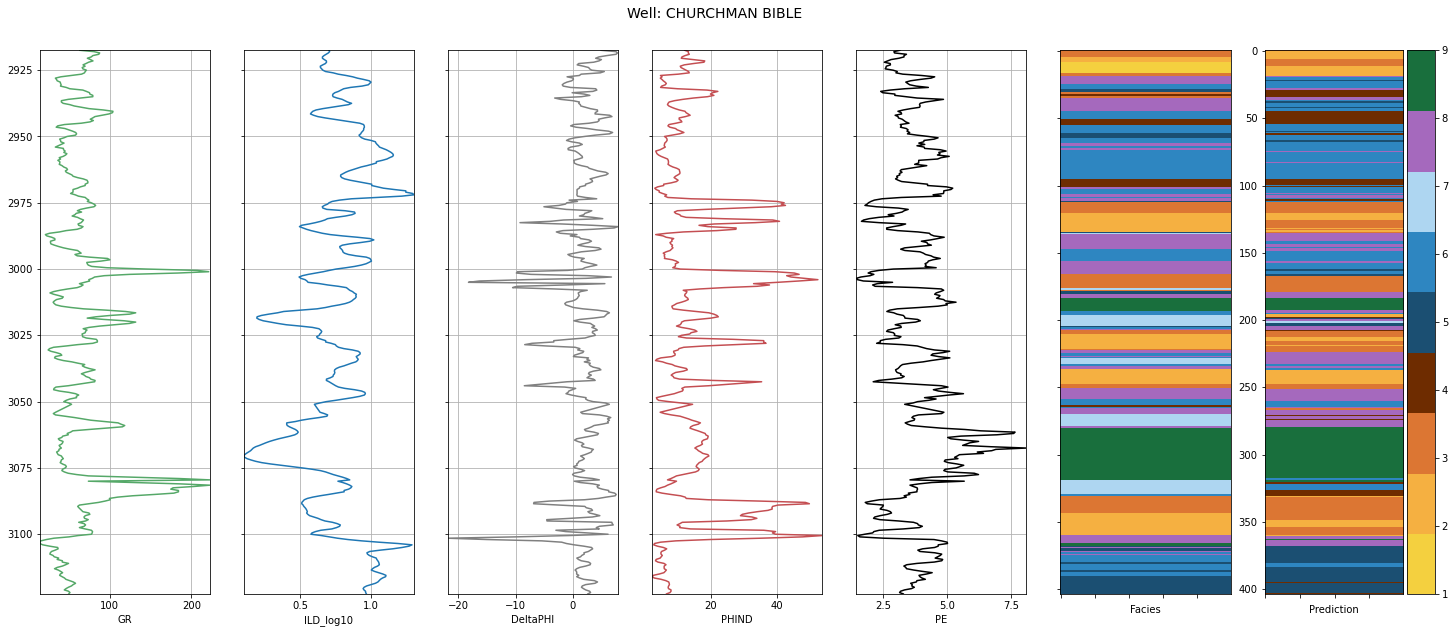

In [74]:
compare_facies_plot(blind2, 'Prediction', facies_colors)

## Summary<a name="summary"></a>
The 9 well-log data set was used to develop a lithology facies classification model. There are 5 well-log measurements and 2 geologically derived features. We expanded the predictor feature numbers to 435, using augment, gradient, and polynomial terms. We tried two classification algorithms, SVM and Gradient Boosting Trees.The performance of gradient boosting trees was better than SVM. The classifier achieved an accuracy of 0.80 on the training data set and 0.56 on the blind left-out data set. There training dataset is still relatively small, and the imbalanced data may be the reason that the model performance dropped sharply in the test data set. 